In [1]:
import pandas as pd
import numpy as np


In [2]:
import os
import urllib
import gdown

In [3]:
TRAIN_URL = 'https://drive.google.com/uc?id=1JNprlyDTnj_FWS4s7Kqj_DK9c9e8paee'
METADATA_URL = 'https://drive.google.com/uc?id=1udArawWgEzEJxjLOBGHHG_lNV1g3PYHh'
TEST_URL = 'https://drive.google.com/uc?id=1Odd-l1rkvlyGnR8TCpqEDMaarPbv9v-D'


In [4]:
def fetch_gdrive_data(url, output):
    gdown.download(url, output, quiet=False)

In [5]:
#fetch_gdrive_data(url= TRAIN_URL, output = '../data/training_data.csv')
#fetch_gdrive_data(url = METADATA_URL, output = '../data/census_metadata.txt')
#fetch_gdrive_data(url = TEST_URL, output = '../data/test_data.csv')

In [6]:
def load_data_and_clean_column_names(data, metadata):
    df = pd.read_csv(data)
    column_names = pd.read_csv('../data/census_income_metadata.txt',
                               sep='|',
                               header = None
                               )[1].iloc[23:68].str.split('\t',
                                                          n = 1,
                                                          expand = True
                                                          )[0].str.lstrip().str.replace("'","")
    column_names = column_names[(column_names != 'adjusted gross income') &
                                (column_names != 'federal income tax liability') &
                                (column_names != 'total person earnings') & 
                                (column_names != 'total person income') &
                                (column_names != 'taxable income amount')].reset_index(drop = True)
    column_names = list(column_names)
    column_names[10] = 'race'
    column_names.extend(['year', 'income'])
    df.columns = column_names
    return df

In [7]:
df = load_data_and_clean_column_names(data= '../data/training_data.csv', metadata= '../data/census_metadata.txt')
df_test = load_data_and_clean_column_names(data= '../data/test_data.csv', metadata= '../data/census_metadata.txt')

Let's begin with a simple model to see how useful a subset of our features are for predictions.

Time to carry out a little feature engineering

In [203]:
df.columns

Index(['age', 'class of worker', 'industry code', 'occupation code',
       'education', 'wage per hour', 'enrolled in edu inst last wk',
       'marital status', 'major industry code', 'major occupation code',
       'race', 'hispanic Origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'capital gains', 'capital losses', 'divdends from stocks',
       'tax filer status', 'region of previous residence',
       'state of previous residence', 'detailed household and family stat',
       'detailed household summary in household', 'instance weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
       'own business or s

In [8]:
def num_to_cat_features(df, num_features:list):
    for feature in list:
        df[feature] = df[feature].astype(str)
    return df

In [9]:
cat_num_features = ['num persons worked for employer', 'own business or self employed', 'veterans benefits']

In [10]:
numerical_features = ['age', 'capital net gains losses', 'divdends from stocks']


cat_features = ['weeks worked in year', 'num persons worked for employer', 'own business or self employed', 'veterans benefits', 
                'class of worker', 'education', 'enrolled in edu inst last wk', 'marital status', 'major industry code', 
                'major occupation code', 'race', 'hispanic Origin', 'sex', 'member of a labor union', 'reason for unemployment', 
                'full or part time employment stat', 'detailed household summary in household', 'live in this house 1 year ago', 
                'citizenship']

target = ['income']

In [11]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [26]:
def bin_weeks_worked(x):
        if x <13:
            return 'less than 13 weeks'
        elif x < 26:
            return 'from 13 to 25 weeks'
        elif x < 39:
            return 'from 26 to 38 weeks'
        else:
            return '39 weeks or more'

In [27]:
features_for_model_1 = ['age', 'capital net gains losses', 'divdends from stocks', 'weeks worked in year', 
                        'num persons worked for employer', 'own business or self employed', 'veterans benefits', 
                        'class of worker', 'education', 'enrolled in edu inst last wk', 'marital status', 'major industry code', 
                        'major occupation code', 'race', 'hispanic Origin', 'sex', 'member of a labor union', 'reason for unemployment', 
                        'full or part time employment stat', 'detailed household summary in household', 'live in this house 1 year ago', 
                        'citizenship']

In [28]:
df['capital net gains losses'] = df['capital gains'] - df['capital losses']
df['weeks worked in year'] = df['weeks worked in year'].apply(bin_weeks_worked)
df[cat_num_features] = df[cat_num_features].astype(str)
df[cat_num_features] = df[cat_num_features].astype(str)

In [32]:
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder

In [23]:
kb_trans = KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy= 'uniform')

In [63]:
from sklearn.compose import ColumnTransformer

num_attribs = ['age', 'capital net gains losses', 'divdends from stocks']

cat_attribs = ['weeks worked in year', 'num persons worked for employer', 'own business or self employed', 'veterans benefits', 
                'class of worker', 'education', 'enrolled in edu inst last wk', 'marital status', 'major industry code', 
                'major occupation code', 'race', 'hispanic Origin', 'sex', 'member of a labor union', 'reason for unemployment', 
                'full or part time employment stat', 'detailed household summary in household', 'live in this house 1 year ago', 
                'citizenship']

column_transform_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
], sparse_threshold=0)


In [48]:
X = df[features_for_model_1].copy()
y = df['income'].copy()
y = y.apply(lambda x: 1 if x == ' 50000+.' else 0)

In [64]:
df_test['capital net gains losses'] = df_test['capital gains'] - df_test['capital losses']
df_test['weeks worked in year'] = df_test['weeks worked in year'].apply(bin_weeks_worked)
df_test[cat_num_features] = df_test[cat_num_features].astype(str)
df_test[cat_num_features] = df_test[cat_num_features].astype(str)

X_test = df_test[features_for_model_1].copy()
y_test = df_test['income'].copy()
y_test = y_test.apply(lambda x: 1 if x == ' 50000+.' else 0)

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
pipe_clf = Pipeline([
  (
    "FeatureEngineering",
    ColumnTransformer(
        [
          ("num", StandardScaler(), num_attribs),
          ("cat", OneHotEncoder(), cat_attribs),
        ],
      #remainder=StandardScaler()
    )
  ),
  #("SMOTE", SMOTE()),
  #(
  #  "PCA_red",
  #  PCA(n_components=10)  
  #),
  ("GradientBooster", GradientBoostingClassifier())
])

In [112]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer

# Create a param grid experimenting with different feature sets and parameters
param_grid = {
              #"SMOTE__sampling_strategy": [0.5, 1],
              "GradientBooster__loss": ['log_loss', 'exponential'],
              "GradientBooster__n_estimators": [100, 150],
              }

# Run a grid search with the pipeline
# Use scoring parameter to maximize the recall score
gs_pipeline = GridSearchCV(cv= 3, estimator= pipe_clf, param_grid=param_grid, verbose=1, scoring=make_scorer(recall_score))
gs_pipeline.fit(X, y)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/alexdcruz/dataiku_task/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV] END GradientBooster__loss=deviance, GradientBooster__n_estimators=100; total time=  22.5s


/Users/alexdcruz/dataiku_task/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV] END GradientBooster__loss=deviance, GradientBooster__n_estimators=100; total time=  22.9s


/Users/alexdcruz/dataiku_task/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV] END GradientBooster__loss=deviance, GradientBooster__n_estimators=100; total time=  20.2s


/Users/alexdcruz/dataiku_task/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV] END GradientBooster__loss=deviance, GradientBooster__n_estimators=150; total time=  29.1s


/Users/alexdcruz/dataiku_task/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV] END GradientBooster__loss=deviance, GradientBooster__n_estimators=150; total time=  29.2s


/Users/alexdcruz/dataiku_task/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


[CV] END GradientBooster__loss=deviance, GradientBooster__n_estimators=150; total time=  29.5s
[CV] END GradientBooster__loss=exponential, GradientBooster__n_estimators=100; total time=  21.0s
[CV] END GradientBooster__loss=exponential, GradientBooster__n_estimators=100; total time=  20.8s
[CV] END GradientBooster__loss=exponential, GradientBooster__n_estimators=100; total time=  20.3s
[CV] END GradientBooster__loss=exponential, GradientBooster__n_estimators=150; total time=  30.2s
[CV] END GradientBooster__loss=exponential, GradientBooster__n_estimators=150; total time=  29.8s
[CV] END GradientBooster__loss=exponential, GradientBooster__n_estimators=150; total time=  31.1s


/Users/alexdcruz/dataiku_task/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('FeatureEngineering',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'capital '
                                                                          'net '
                                                                          'gains '
                                                                          'losses',
                                                                          'divdends '
                                                                          'from '
                                                                          'stocks']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['weeks '
                                                                          'worked '
                                                                          'in '
                                                                          'year',
                                                                          'num '
                                                                          'persons '
                                                                          'worked '
                                                                          'for '
                                                                          'employer',
                                                                          'own '
                                                                          'business '
                                                                          'or '
                                                                          'self '
                                                                          'employed',
                                                                          'veterans '
                                                                          'benefits',
                                                                          'class '
                                                                          'of '
                                                                          'worker'...
                                                                          'unemployment',
                                                                          'full '
                                                                          'or '
                                                                          'part '
                                                                          'time '
                                                                          'employment '
                                                                          'stat',
                                                                          'detailed '
                                                                          'household '
                                                                          'summary '
                                                                          'in '
                                                                          'household',
                                                                          'live '
                                                                          'in '
                                                                          'this '
                                                                         

In [60]:
from sklearn.metrics import recall_score, make_scorer, accuracy_score, f1_score

In [65]:
best_model = gs_pipeline.best_estimator_
print(gs_pipeline.best_params_)

# Make predictions on our validation set and see recall score of best model
y_validation_preds = best_model.predict(X_test)
print(accuracy_score(y_test, y_validation_preds))
print(f1_score(y_test, y_validation_preds) )


{'GradientBooster__loss': 'deviance', 'GradientBooster__n_estimators': 150}
0.9553933902025842
0.5423693953105717


In [59]:
y.value_counts(normalize = True)

0    0.937942
1    0.062058
Name: income, dtype: float64

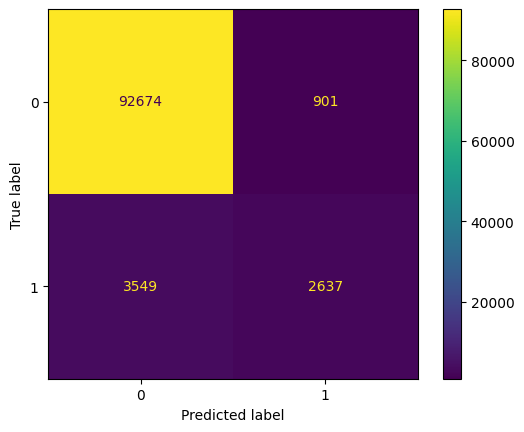

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_validation_preds, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_model.classes_)
disp.plot()
plt.show()

In [68]:
recall_score(y_test, y_validation_preds)

0.4262851600387973

Comparing our accuracy to the baseline we get a marginal gain. This could be sufficient for the problem at hand or perhaps we can improve things further. 

Accuracy is also not a great metric to use for problems with huge class imbalances. 
We can see here that although we are good at predicting our majority class correctly, we mislabel our minority class more often than not.

Let's try to address our class imbalance

In [72]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [74]:
pipe_clf = Pipeline([
  (
    "FeatureEngineering",
    ColumnTransformer(
        [
          ("num", StandardScaler(), num_attribs),
          ("cat", OneHotEncoder(), cat_attribs),
        ],
      
    )
  ),
  ("SMOTE", SMOTE()),
  ("UNDER", RandomUnderSampler()),
  ("GradientBooster", GradientBoostingClassifier())
])
param_grid = {
              "SMOTE__sampling_strategy": [0.15, 0.2],
              "UNDER__sampling_strategy": [0.5],
              "GradientBooster__loss": ['log_loss', 'exponential'],
              "GradientBooster__n_estimators": [150],
              }

# Run a grid search with the pipeline
# Use scoring parameter to maximize the recall score
gs_pipeline = GridSearchCV(cv= 3, estimator= pipe_clf, param_grid=param_grid, verbose=1, scoring=make_scorer(f1_score), n_jobs= -1)
gs_pipeline.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('FeatureEngineering',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'capital '
                                                                          'net '
                                                                          'gains '
                                                                          'losses',
                                                                          'divdends '
                                                                          'from '
                                                                          'stocks']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['weeks '
                                                                          'worked '
                                                                          'in '
                                                                          'year',
                                                                          'num '
                                                                          'persons '
                                                                          'worked '
                                                                          'for '
                                                                          'employer',
                                                                          'own '
                                                                          'business '
                                                                          'or '
                                                                          'self '
                                                                          'employed',
                                                                          'veterans '
                                                                          'benefits',
                                                                          'class '
                                                                          'of '
                                                                          'worker'...
                                                                          'year '
                                                                          'ago',
                                                                          'citizenship'])])),
                                       ('SMOTE', SMOTE()),
                                       ('UNDER', RandomUnderSampler()),
                                       ('GradientBooster',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'GradientBooster__loss': ['log_loss', 'exponential'],
                         'GradientBooster__n_estimators': [150],
                         'SMOTE__sampling_strategy': [0.15, 0.2],
                         'UNDER__sampling_strategy': [0.5]},
             scoring=make_scorer(f1_score), verbose=1)

In [75]:
y_test.value_counts(normalize = True)

0    0.937992
1    0.062008
Name: income, dtype: float64

{'GradientBooster__loss': 'log_loss', 'GradientBooster__n_estimators': 150, 'SMOTE__sampling_strategy': 0.2, 'UNDER__sampling_strategy': 0.5}
accuracy 0.9328294624151723
f1 0.5677610785009354


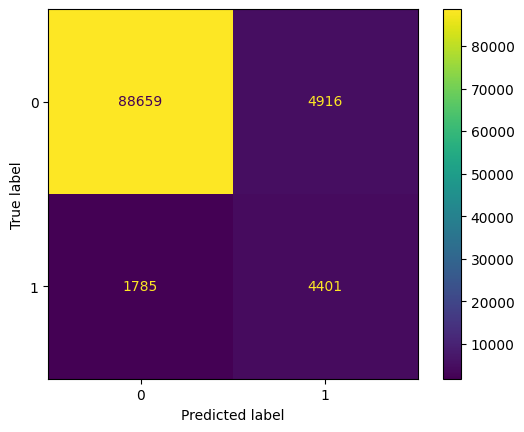

In [76]:
best_model_smote = gs_pipeline.best_estimator_
print(gs_pipeline.best_params_)

# Make predictions on our validation set and see recall score of best model
y_validation_preds = best_model_smote.predict(X_test)
print("accuracy", accuracy_score(y_test, y_validation_preds))
print("f1", f1_score(y_test, y_validation_preds) )

cm = confusion_matrix(y_test, y_validation_preds, labels=best_model_smote.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_model_smote.classes_)
disp.plot()
plt.show()

In [77]:
recall_score(y_test, y_validation_preds)

0.7114451988360815

Okay so we sacrificed some accuracy but improved Recall significantly. Time to compare some out of the box models

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

svc_clf = SVC()

logreg = LogisticRegression(penalty = 'l2', )

dectreeclf = DecisionTreeClassifier(max_features=14,min_samples_leaf=100,random_state=10)

from xgboost import XGBClassifier

xgboostclf= XGBClassifier()

from catboost import CatBoostClassifier

catboostclf= CatBoostClassifier(learning_rate=0.04)

#import lightgbm as lgb

#lgb_clf = lgb()


In [86]:
models = {"XGBoost" : {"params": {},
                        "model": xgboostclf},
          "LOGREG": {"params": {},
                        "model": logreg},
           "SVC_clf": {"params": {},
                        "model": svc_clf},
           "DECTREE": {"params": {},
                        "model": dectreeclf}
}

In [92]:
for x in models:
    print(x + '__')

XGBoost__
LOGREG__
SVC_clf__
DECTREE__


In [124]:
import time
from typing import Any, Callable, Optional

def timed(func: Callable[[Any], Any]):
    """Simple decorator that print wall time for a given function."""

    def _inner(*args: Optional[Any], **kwargs: Optional[Any]) -> Any:
        print(f"Starting process '{func}'...")
        started = time.time()
        response = func(*args, **kwargs)
        ended = time.time()
        print(f"Finished process '{func}' in {ended - started:.2f}s")
        return response

    return _inner

@timed
def run_model(modelname, verbosity = 1):

  pipe_clf = Pipeline([
    (
      "FeatureEngineering",
      ColumnTransformer(
          [
            ("num", StandardScaler(), num_attribs),
            ("cat", OneHotEncoder(), cat_attribs),
          ],
        
      )
    ),
    ("SMOTE", SMOTE()),
    ("UNDER", RandomUnderSampler()),
    (modelname, models[modelname]["model"])
  ])
  param_grid = {
                "SMOTE__sampling_strategy": [0.2],
                "UNDER__sampling_strategy": [0.5],
                }
  param_grid.update(models[modelname]["params"])
  
  skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

  # Run a grid search with the pipeline
  # Use scoring parameter to maximize the recall score
  gs_pipeline = GridSearchCV(cv= skf, estimator= pipe_clf, param_grid=param_grid, verbose=verbosity, scoring=make_scorer(f1_score), n_jobs= -1)
  gs_pipeline.fit(X, y)

  models[modelname]["best_model"] = gs_pipeline.best_estimator_
  models[modelname]["best_model_params"] = gs_pipeline.best_params_

  # Make predictions on our validation set and see recall score of best model
  models[modelname]["y_validation_preds"] = models[modelname]["best_model"].predict(X_test)
  models[modelname]["accuracy"] =  accuracy_score(y_test, models[modelname]["y_validation_preds"])
  models[modelname]["f1"] = f1_score(y_test, models[modelname]["y_validation_preds"]) 

  cm = confusion_matrix(y_test, models[modelname]["y_validation_preds"], labels=models[modelname]["best_model"].classes_)
  models[modelname]["confusion_matrix"] = ConfusionMatrixDisplay(confusion_matrix=cm,
                                                                display_labels=models[modelname]["best_model"].classes_)
  models[modelname]["confusion_matrix"].plot()
  plt.show()






Fitting 3 folds for each of 1 candidates, totalling 3 fits


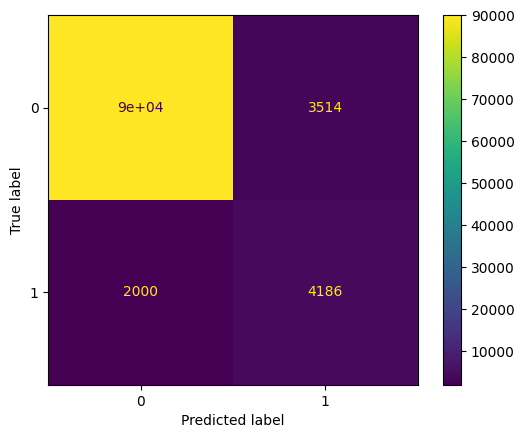

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/alexdcruz/dataiku_task/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alexdcruz/dataiku_task/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

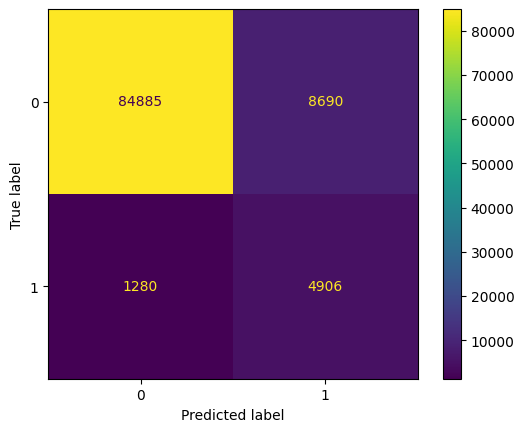

Fitting 3 folds for each of 1 candidates, totalling 3 fits


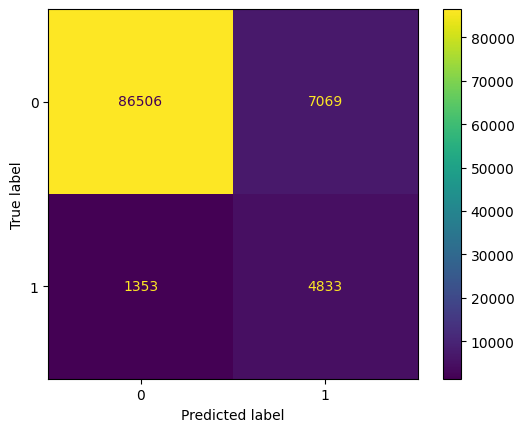

Fitting 3 folds for each of 1 candidates, totalling 3 fits


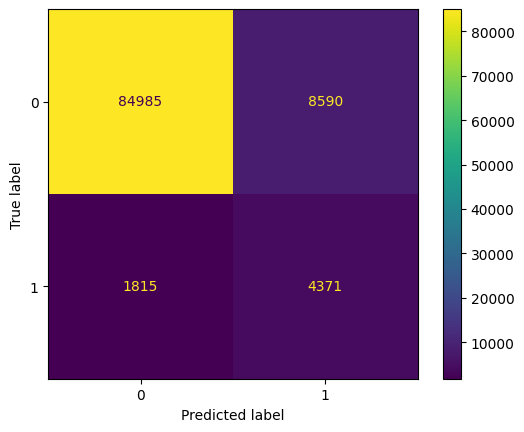

{'XGBoost': {'params': {}, 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), 'best_model': Pipeline(steps=[('FeatureEngineering',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age',
                         

In [106]:
for model in models:
    run_model(model)
print(models)

In [110]:
for model in models:
    print(model, models[model]['accuracy'], models[model]['f1'])

XGBoost 0.9447278996802357 0.6029094051562724
LOGREG 0.9000611461392729 0.4960064705287635
SVC_clf 0.9155782319744189 0.5343874391862008
DECTREE 0.8957007247321097 0.45657283125293785


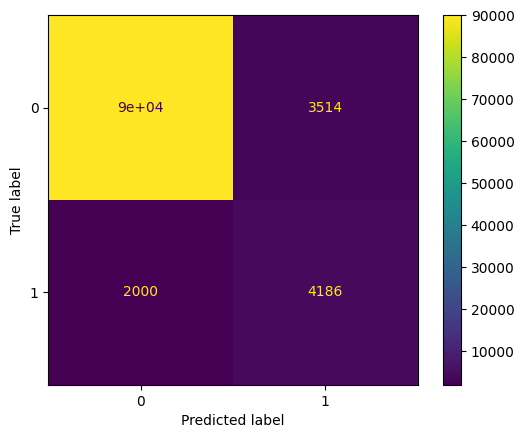

In [111]:
models['XGBoost']['confusion_matrix'].plot()

The untuned XGBoost model has good accuracy and F1 score so let's tune and try to improve things further.

In [116]:
models["XGBoost"]['params'] = { 'max_depth': [3,6,10],
                               'learning_rate': [0.01, 0.05, 0.1],
                               'n_estimators': [100, 500, 1000],
                               'colsample_bytree': [0.3, 0.7]
                               }

In [120]:
models["XGBoost"]["model"] = XGBClassifier(random_state = 42)

In [125]:
from pickle import dump, load

In [126]:
filename = "trained_model.sav"
dump([model, X, X_test, y, y_test], open(filename, 'wb'))

In [127]:
import shap

ModuleNotFoundError: No module named 'shap'

In [161]:
new_cat_attribs = models["XGBoost"]["best_model"].named_steps["FeatureEngineering"]\
.named_transformers_["cat"].get_feature_names_out(cat_attribs)
# concatenate categorical columns with numerical columns to get all columns names
all_cols = np.concatenate([num_attribs, new_cat_attribs])


In [191]:
import seaborn as sns
from sklearn.inspection import permutation_importance

In [172]:
importance_df[importance_df["colors"] == "red"]

,feature,importance,abs_importance,colors


In [199]:
def plot_feature_importances(model, svc_kernel = "linear"):
    '''
    Plots feature importances for XGBoost, DECTREE and LOGREG.
    Will try to generate coefs for SVC if the kernel is set to linear
    If kernel set to rbf use permutation importance for SVC_clf but warning that this takes a long time and computationally exp.
    '''
    new_cat_attribs = models[model]["best_model"].named_steps["FeatureEngineering"]\
    .named_transformers_["cat"].get_feature_names_out(cat_attribs)
    # concatenate categorical columns with numerical columns to get all columns names
    all_cols = np.concatenate([num_attribs, new_cat_attribs])
    if model in ["XGBoost", "DECTREE"]:
        importances = models[model]["best_model"].named_steps[model].feature_importances_
    elif model in ["LOGREG"]:
        importances = models[model]["best_model"].named_steps[model].coef_
    elif model in ["SVC_clf"] and svc_kernel == "linear":
        try:
            importances = models[model]["best_model"].named_steps[model].coef_
        except:
            # with rbf kernel use permutation importance for feature importance
            #importances = permutation_importance(models[model]["best_model"], X_test, y_test)
            #Takes too long
            return "Only SVC with Linear kernel can generate model coefs and feature importances"
    elif model in ["SVC_clf"] and svc_kernel == "rbf":
        importances = permutation_importance(models[model]["best_model"], X_test, y_test)

    importance_df = pd.DataFrame(zip(all_cols, importances), columns=["feature", "importance"])
    #Work out absolute feature importance
    importance_df["abs_importance"] = importance_df["importance"].apply(lambda x: abs(x))
    #Colour code for features with positive impact on predictions
    importance_df["colors"] = importance_df["importance"].apply(lambda x: "green" if x > 0 else "red")
    importance_df = importance_df.sort_values("abs_importance", ascending=False)



    %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.barplot(y="feature",
                x="abs_importance",
                data=importance_df.head(25),
            palette=importance_df.head(25)["colors"], orient='h')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
    ax.set_title("Top 25 Features", fontsize=25)
    ax.set_xlabel("Importance", fontsize=22)
    ax.set_ylabel("Feature Name", fontsize=22)

I learnt about Permutation Importance after looking up how to generate feature importance for SVM Classifiers

Feature importance techniques score each predictor on their ability to improve predictions. 
This allows us to rank the features in our model based on their importance or power to predict our target variable.

The idea behind Permutation Importance is that inputs that are useful for prediction contain valuable information and so by randomly shuffling the values of that feature you are destroying that information and thus reducing the quality of our predictions. 

If there is a small decrease in quality then the feature wasn't great at determining the correct prediction and so the model is still quite good without it. 
However if there is a large decrease in the quality, then the information in that feature had a large impact on your predictions.

This requires us to shuffle a predictor, predict using the model, assess the quality of the new predictions and calculate the decrease in performance. Then by carrying out this process for all features you can rank them in terms of predictive usefulness.

As this has to happen across all features it can be computationally expensive.

Realising that I have lost information by using net capital gains/losses - Having gains of 500 and losses of 500 would be net 0 but this could indicate a very different profile to someone who has 0 gains and zero losses. 